In [1]:
import requests
from bs4 import BeautifulSoup 
import pandas as pd
import os
import shutil
import numpy as np

In [2]:
years = list(range(1985, 2022))

In [3]:
url_start = "https://www.basketball-reference.com/awards/awards_{}.html"

In [4]:
for year in years:
    url = url_start.format(year)
    data = requests.get(url)
    with open('mvp/{}.html'.format(year), 'w+', encoding = 'utf-8') as f:
        f.write(data.text)

In [5]:
dfs = []

for year in years:
    with open("mvp/{}.html".format(year), encoding ="utf-8") as f:
        page = f.read()
        
    soup = BeautifulSoup(page, 'html.parser')
    soup.find('tr', class_ = "over_header").decompose()
    mvp_table = soup.find_all(id='mvp')[0]
    mvp_df = pd.read_html(str(mvp_table))[0]
    mvp_df['Year'] = year
    
    dfs.append(mvp_df)

In [6]:
mvps = pd.concat(dfs)

In [7]:
mvps.head()

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
0,1,Larry Bird,28,BOS,73.0,763.0,780,0.978,80,39.5,...,10.5,6.6,1.6,1.2,0.522,0.427,0.882,15.7,0.238,1985
1,2,Magic Johnson,25,LAL,1.0,264.0,780,0.338,77,36.1,...,6.2,12.6,1.5,0.3,0.561,0.189,0.843,12.7,0.220,1985
2,3,Moses Malone,29,PHI,0.0,218.0,780,0.279,79,37.4,...,13.1,1.6,0.8,1.6,0.469,0.000,0.815,11.9,0.193,1985
3,4,Kareem Abdul-Jabbar,37,LAL,0.0,206.0,780,0.264,79,33.3,...,7.9,3.2,0.8,2.1,0.599,0.000,0.732,11.2,0.204,1985
4,5,Terry Cummings,23,MIL,2.0,138.0,780,0.177,79,34.5,...,9.1,2.9,1.5,0.8,0.495,0.000,0.741,10.7,0.189,1985


In [8]:
mvps.to_csv('mvps.csv')

Let's try doing this with player stats now.

1. The bball-ref player stats table uses javascript, so we will have to account for that.

In [9]:
player_stats_url = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html"

In [10]:
 for year in years:
    url = player_stats_url.format(year)
    data = requests.get(url)
    with open('player/{}.html'.format(year), 'w+', encoding = 'utf-8') as f:
        f.write(data.text)

In [11]:
df = []
for year in years:
    
    with open('player/{}.html'.format(year), encoding = 'utf-8') as f:
        page = f.read()

        soup = BeautifulSoup(page, 'html.parser')
        soup.find('tr', class_ = "thead").decompose()
        player_table = soup.find_all(id='per_game_stats')[0]
        player_df = pd.read_html(str(player_table))[0]
        player_df['Year'] = year
        
        df.append(player_df)

In [12]:
player_df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1,Precious Achiuwa,PF,21,MIA,61,4,12.1,2.0,3.7,...,1.2,2.2,3.4,0.5,0.3,0.5,0.7,1.5,5.0,2021
1,2,Jaylen Adams,PG,24,MIL,7,0,2.6,0.1,1.1,...,0.0,0.4,0.4,0.3,0.0,0.0,0.0,0.1,0.3,2021
2,3,Steven Adams,C,27,NOP,58,58,27.7,3.3,5.3,...,3.7,5.2,8.9,1.9,0.9,0.7,1.3,1.9,7.6,2021
3,4,Bam Adebayo,C,23,MIA,64,64,33.5,7.1,12.5,...,2.2,6.7,9.0,5.4,1.2,1.0,2.6,2.3,18.7,2021
4,5,LaMarcus Aldridge,C,35,TOT,26,23,25.9,5.4,11.4,...,0.7,3.8,4.5,1.9,0.4,1.1,1.0,1.8,13.5,2021


In [13]:
player_df = pd.concat(df)

In [14]:
player_df.to_csv('players.csv')

Scrape team records per year

In [15]:
team_stats_url = 'https://www.basketball-reference.com/leagues/NBA_{}_standings.html'

In [16]:
for year in years:
    url = team_stats_url.format(year)
    data = requests.get(url)

    with open ('team/{}.html'.format(year), 'w+',encoding = 'utf-8') as f:
        f.write(data.text)

In [17]:
dfs = []

for year in years:
    with open('team/{}.html'.format(year), encoding = 'utf-8') as f:
        page = f.read()

        soup = BeautifulSoup(page, 'html.parser')
        soup.find('tr', class_='thead').decompose()
        team_table = soup.find_all(id = 'divs_standings_E')
        team = pd.read_html(str(team_table))[0]
        team['Year'] = year
        team['Team'] = team['Eastern Conference']
        del team['Eastern Conference']
        dfs.append(team)

        soup = BeautifulSoup(page, 'html.parser')
        soup.find('tr', class_='thead').decompose()
        team_table = soup.find_all(id = 'divs_standings_W')
        team = pd.read_html(str(team_table))[0]
        team['Year'] = year
        team['Team'] = team['Western Conference']
        del team['Western Conference']
        dfs.append(team)

In [18]:
teams = pd.concat(dfs)
teams['GB'] = teams['GB'].str.replace('—',"0",regex=False)

In [19]:
teams = teams[~teams['W'].str.contains('Division')]

In [20]:
teams['Team'] = teams['Team'].str.replace('*',"", regex=False)

In [21]:
teams.to_csv('teams.csv')

Data Cleaning

In [22]:
mvps = pd.read_csv('mvps.csv')

In [23]:
#Only select the cols that we need, since the players table already contains game stats
mvps = mvps[['Player','Year','Pts Won','Pts Max', 'Share',]]

Clean player data and combine with MVP table


In [24]:
players = pd.read_csv('players.csv')
players

,Unnamed: 0,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,0,1,Kareem Abdul-Jabbar*,C,37,LAL,79,79,33.3,9.2,...,2.1,5.8,7.9,3.2,0.8,2.1,2.5,3.0,22.0,1985
1,1,2,Alvan Adams,PF,30,PHO,82,69,26.0,5.8,...,1.9,4.2,6.1,3.8,1.4,0.6,2.4,3.1,14.7,1985
2,2,3,Mark Aguirre,SF,25,DAL,80,79,33.7,9.9,...,2.4,3.6,6.0,3.1,0.8,0.3,3.2,3.1,25.7,1985
3,3,4,Danny Ainge,SG,25,BOS,75,73,34.2,5.6,...,1.0,2.6,3.6,5.3,1.6,0.1,2.0,3.0,12.9,1985
4,4,5,Chuck Aleksinas,C,25,GSW,74,4,15.1,2.2,...,1.2,2.5,3.6,0.5,0.2,0.2,1.0,2.3,5.1,1985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20574,725,536,Delon Wright,PG,28,SAC,27,8,25.8,3.9,...,1.0,2.9,3.9,3.6,1.6,0.4,1.3,1.1,10.0,2021
20575,726,537,Thaddeus Young,PF,32,CHI,68,23,24.3,5.4,...,2.5,3.8,6.2,4.3,1.1,0.6,2.0,2.2,12.1,2021
20576,727,538,Trae Young,PG,22,ATL,63,63,33.7,7.7,...,0.6,3.3,3.9,9.4,0.8,0.2,4.1,1.8,25.3,2021
20577,728,539,Cody Zeller,C,28,CHO,48,21,20.9,3.8,...,2.5,4.4,6.8,1.8,0.6,0.4,1.1,2.5,9.4,2021


In [25]:
# remove unnecessary cols
del players['Unnamed: 0']
del players['Rk']

In [26]:
# remove '*' next to player names for future join
players['Player'] = players['Player'].str.replace('*','', regex=False)

In [27]:
#remove duplicate player rows for players for example who were traded
players.groupby(['Player','Year'])

In [28]:
def single_row(df):
    if df.shape[0] == 1:
        return df
    else:
        row = df[df['Tm'] == 'TOT']
        row['Tm'] = df.iloc[-1,:]['Tm']
        return row
players = players.groupby(['Player','Year']).apply(single_row)

In [29]:
players.index = players.index.droplevel()

In [30]:
players.index = players.index.droplevel()

In [31]:
players[players['Player'] == 'LeBron James']

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
9524,LeBron James,SG,19,CLE,79,79,39.5,7.9,18.9,.417,...,1.3,4.2,5.5,5.9,1.6,0.7,3.5,1.9,20.9,2004
10142,LeBron James,SF,20,CLE,80,80,42.4,9.9,21.1,.472,...,1.4,6.0,7.4,7.2,2.2,0.7,3.3,1.8,27.2,2005
10737,LeBron James,SF,21,CLE,79,79,42.5,11.1,23.1,.480,...,0.9,6.1,7.0,6.6,1.6,0.8,3.3,2.3,31.4,2006
11299,LeBron James,SF,22,CLE,78,78,40.9,9.9,20.8,.476,...,1.1,5.7,6.7,6.0,1.6,0.7,3.2,2.2,27.3,2007
11876,LeBron James,SF,23,CLE,75,74,40.4,10.6,21.9,.484,...,1.8,6.1,7.9,7.2,1.8,1.1,3.4,2.2,30.0,2008
12490,LeBron James,SF,24,CLE,81,81,37.7,9.7,19.9,.489,...,1.3,6.3,7.6,7.2,1.7,1.1,3.0,1.7,28.4,2009
13107,LeBron James,SF,25,CLE,76,76,39.0,10.1,20.1,.503,...,0.9,6.4,7.3,8.6,1.6,1.0,3.4,1.6,29.7,2010
13732,LeBron James,SF,26,MIA,79,79,38.8,9.6,18.8,.510,...,1.0,6.5,7.5,7.0,1.6,0.6,3.6,2.1,26.7,2011
14336,LeBron James,SF,27,MIA,62,62,37.5,10.0,18.9,.531,...,1.5,6.4,7.9,6.2,1.9,0.8,3.4,1.5,27.1,2012
14894,LeBron James,PF,28,MIA,76,76,37.9,10.1,17.8,.565,...,1.3,6.8,8.0,7.3,1.7,0.9,3.0,1.4,26.8,2013


In [32]:
combined = players.merge(mvps, how ='outer', on = ['Player','Year'])

In [33]:
combined.to_csv('combined_plmp.csv')

In [34]:
players

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
492,A.C. Green,PF,22,LAL,82,1,18.8,2.5,4.7,.539,...,2.0,2.7,4.6,0.7,0.6,0.6,1.2,2.8,6.4,1986
891,A.C. Green,PF,23,LAL,79,72,28.4,4.0,7.4,.538,...,2.7,5.1,7.8,1.1,0.9,1.0,1.3,2.2,10.8,1987
1293,A.C. Green,PF,24,LAL,82,64,32.1,3.9,7.8,.503,...,3.0,5.7,8.7,1.1,1.1,0.5,1.5,2.5,11.4,1988
1742,A.C. Green,PF,25,LAL,82,82,30.6,4.9,9.2,.529,...,3.1,5.9,9.0,1.3,1.1,0.7,1.5,2.1,13.3,1989
2204,A.C. Green,PF,26,LAL,82,82,33.0,4.7,9.8,.478,...,3.2,5.5,8.7,1.1,0.8,0.6,1.4,2.5,12.9,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8630,Željko Rebrača,C,29,DET,74,4,15.9,2.6,5.1,.505,...,1.1,2.8,3.9,0.5,0.4,1.0,1.1,2.6,6.9,2002
9130,Željko Rebrača,C,30,DET,30,12,16.3,2.7,4.8,.552,...,0.9,2.2,3.1,0.3,0.2,0.6,1.0,2.6,6.6,2003
9711,Željko Rebrača,C,31,ATL,24,2,11.4,1.4,3.2,.442,...,1.0,1.5,2.4,0.3,0.2,0.5,0.7,2.2,3.8,2004
10311,Željko Rebrača,C,32,LAC,58,2,16.0,2.3,4.0,.568,...,0.8,2.3,3.2,0.4,0.2,0.7,0.8,2.2,5.8,2005


In [35]:
combined[combined['Pts Won'] > 0]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
149,Adrian Dantley,SF,30,UTA,76,75,36.1,10.8,19.1,.563,...,3.5,0.8,0.1,3.0,2.7,29.8,1986,2.0,780.0,0.003
151,Adrian Dantley,SF,32,DET,69,50,31.1,6.4,12.5,.514,...,2.5,0.6,0.1,2.0,2.1,20.0,1988,1.0,800.0,0.001
203,Al Jefferson,C,29,CHA,73,73,35.0,9.6,18.8,.509,...,2.1,0.9,1.1,1.7,2.4,21.8,2014,34.0,1250.0,0.027
295,Alex English,SF,31,DEN,81,81,36.1,11.6,22.4,.518,...,4.2,1.2,0.6,3.1,3.2,27.9,1985,12.0,780.0,0.015
296,Alex English,SF,32,DEN,81,81,37.3,11.7,23.3,.504,...,4.0,0.9,0.4,3.1,2.9,29.8,1986,55.0,780.0,0.071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15545,Vince Carter,SF,24,TOR,75,75,39.7,10.2,22.1,.460,...,3.9,1.5,1.1,2.2,2.7,27.6,2001,7.0,1240.0,0.006
15549,Vince Carter,SF-SG,28,NJN,77,76,36.7,9.0,20.0,.452,...,4.2,1.4,0.6,2.2,3.2,24.5,2005,3.0,1270.0,0.002
15944,World B. Free,SG,31,CLE,71,50,31.7,8.6,18.7,.459,...,4.5,1.1,0.2,2.0,2.3,22.5,1985,2.0,780.0,0.003
15977,Yao Ming,C,23,HOU,82,82,32.8,6.5,12.5,.522,...,1.5,0.3,1.9,2.5,3.3,17.5,2004,1.0,1230.0,0.001


Address NaN values

In [36]:
combined = combined.fillna(0)

In [37]:
teams = pd.read_csv('teams.csv')

Team names are not consistent across tables, let's address that


In [38]:
teams['Team'].unique()

array(['Boston Celtics', 'Philadelphia 76ers', 'New Jersey Nets',
       'Washington Bullets', 'New York Knicks', 'Milwaukee Bucks',
       'Detroit Pistons', 'Chicago Bulls', 'Cleveland Cavaliers',
       'Atlanta Hawks', 'Indiana Pacers', 'Denver Nuggets',
       'Houston Rockets', 'Dallas Mavericks', 'Utah Jazz',
       'San Antonio Spurs', 'Kansas City Kings', 'Los Angeles Lakers',
       'Portland Trail Blazers', 'Phoenix Suns', 'Seattle SuperSonics',
       'Los Angeles Clippers', 'Golden State Warriors',
       'Sacramento Kings', 'Charlotte Hornets', 'Miami Heat',
       'Orlando Magic', 'Minnesota Timberwolves', 'Toronto Raptors',
       'Vancouver Grizzlies', 'Washington Wizards', 'Memphis Grizzlies',
       'New Orleans Hornets', 'Charlotte Bobcats',
       'New Orleans/Oklahoma City Hornets', 'Oklahoma City Thunder',
       'Brooklyn Nets', 'New Orleans Pelicans'], dtype=object)

In [39]:
combined['Tm'] = combined['Tm'].str.replace('CHO','CHA',regex=False)
combined['Tm'] = combined['Tm'].str.replace('CHH','CHB',regex=False)

In [40]:
combined['Tm'].unique()

array(['LAL', 'PHO', 'DAL', 'MIA', 'CLE', 'WSB', 'CHI', 'GSW', 'IND',
       'WAS', 'MIN', 'BOS', 'HOU', 'DEN', 'ORL', 'NOH', 'TOR', 'SAC',
       'CHA', 'POR', 'DET', 'PHI', 'UTA', 'MIL', 'VAN', 'SEA', 'NJN',
       'NOK', 'LAC', 'OKC', 'ATL', 'MEM', 'NYK', 'NOP', 'BRK', 'SAS',
       'CHB', 'KCK'], dtype=object)

In [41]:
abbr = {}

with open('team_abbr.csv') as f:
    lines = f.readlines()
    for line in lines[1:]:
        abbrev, name = line.replace('\n',"").split(",")
        abbr[abbrev] = name

In [42]:
abbr

{'ATL': 'Atlanta Hawks',
 'BOS': 'Boston Celtics',
 'BRK': 'Brooklyn Nets',
 'CHB': 'Charlotte Bobcats',
 'CHA': 'Charlotte Hornets',
 'CHH': 'Charlotte Hornets',
 'CHI': 'Chicago Bulls',
 'CLE': 'Cleveland Cavaliers',
 'DAL': 'Dallas Mavericks',
 'DEN': 'Denver Nuggets',
 'DET': 'Detroit Pistons',
 'GSW': 'Golden State Warriors',
 'HOU': 'Houston Rockets',
 'IND': 'Indiana Pacers',
 'KCK': 'Kansas City Kings',
 'LAC': 'Los Angeles Clippers',
 'LAL': 'Los Angeles Lakers',
 'MEM': 'Memphis Grizzlies',
 'MIA': 'Miami Heat',
 'MIL': 'Milwaukee Bucks',
 'MIN': 'Minnesota Timberwolves',
 'NJN': 'New Jersey Nets',
 'NOH': 'New Orleans Hornets',
 'NOK': 'New Orleans/Oklahoma City Hornets',
 'NOP': 'New Orleans Pelicans',
 'NYK': 'New York Knicks',
 'OKC': 'Oklahoma City Thunder',
 'ORL': 'Orlando Magic',
 'PHI': 'Philadelphia 76ers',
 'PHO': 'Phoenix Suns',
 'POR': 'Portland Trail Blazers',
 'SAC': 'Sacramento Kings',
 'SAS': 'San Antonio Spurs',
 'SEA': 'Seattle SuperSonics',
 'TOR': 'Toront

In [43]:
combined['Team'] = combined['Tm'].map(abbr)

In [44]:
stats = combined.merge(teams, how = 'left', on = ['Team','Year'])

In [45]:
stats

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,Share,Team,Unnamed: 0,W,L,W/L%,GB,PS/G,PA/G,SRS
0,A.C. Green,PF,22,LAL,82,1,18.8,2.5,4.7,.539,...,0.0,Los Angeles Lakers,8.0,62.0,20.0,0.756,0.0,117.3,109.5,6.84
1,A.C. Green,PF,23,LAL,79,72,28.4,4.0,7.4,.538,...,0.0,Los Angeles Lakers,8.0,65.0,17.0,0.793,0.0,117.8,108.5,8.32
2,A.C. Green,PF,24,LAL,82,64,32.1,3.9,7.8,.503,...,0.0,Los Angeles Lakers,8.0,62.0,20.0,0.756,0.0,112.8,107.0,4.81
3,A.C. Green,PF,25,LAL,82,82,30.6,4.9,9.2,.529,...,0.0,Los Angeles Lakers,8.0,57.0,25.0,0.695,0.0,114.7,107.5,6.38
4,A.C. Green,PF,26,LAL,82,82,33.0,4.7,9.8,.478,...,0.0,Los Angeles Lakers,9.0,63.0,19.0,0.768,0.0,110.7,103.9,6.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16115,Željko Rebrača,C,29,DET,74,4,15.9,2.6,5.1,.505,...,0.0,Detroit Pistons,8.0,50.0,32.0,0.610,0.0,94.3,92.2,1.69
16116,Željko Rebrača,C,30,DET,30,12,16.3,2.7,4.8,.552,...,0.0,Detroit Pistons,8.0,50.0,32.0,0.610,0.0,91.4,87.7,2.97
16117,Željko Rebrača,C,31,ATL,24,2,11.4,1.4,3.2,.442,...,0.0,Atlanta Hawks,14.0,28.0,54.0,0.341,33.0,92.8,97.5,-5.00
16118,Željko Rebrača,C,32,LAC,58,2,16.0,2.3,4.0,.568,...,0.0,Los Angeles Clippers,9.0,37.0,45.0,0.451,25.0,95.7,96.5,-0.47


In [46]:
del stats['Unnamed: 0']

In [47]:
stats.dtypes

Player      object
Pos         object
Age         object
Tm          object
G           object
GS          object
MP          object
FG          object
FGA         object
FG%         object
3P          object
3PA         object
3P%         object
2P          object
2PA         object
2P%         object
eFG%        object
FT          object
FTA         object
FT%         object
ORB         object
DRB         object
TRB         object
AST         object
STL         object
BLK         object
TOV         object
PF          object
PTS         object
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
Team        object
W          float64
L          float64
W/L%       float64
GB         float64
PS/G       float64
PA/G       float64
SRS        float64
dtype: object

In [48]:
stats = stats.apply(pd.to_numeric, errors='ignore')

In [49]:
stats.dtypes

Player      object
Pos         object
Age          int64
Tm          object
G            int64
GS           int64
MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
3P%        float64
2P         float64
2PA        float64
2P%        float64
eFG%       float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS        float64
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
Team        object
W          float64
L          float64
W/L%       float64
GB         float64
PS/G       float64
PA/G       float64
SRS        float64
dtype: object

In [50]:
stats.to_csv('player_mvp_stats.csv')

In [51]:
scoring_leaders = stats[stats['G'] > 70].sort_values('PTS', ascending = False).head(10)

<AxesSubplot:xlabel='Player'>

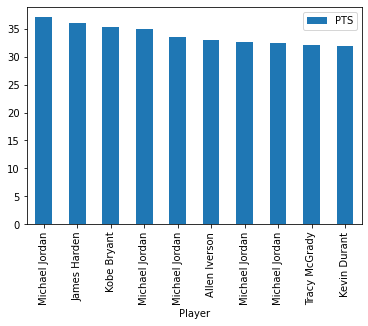

In [52]:
scoring_leaders.plot.bar('Player', 'PTS')

In [53]:
high_scores = stats.groupby('Year').apply(lambda x: x.sort_values('PTS',ascending=False).head(1))

<AxesSubplot:xlabel='Year'>

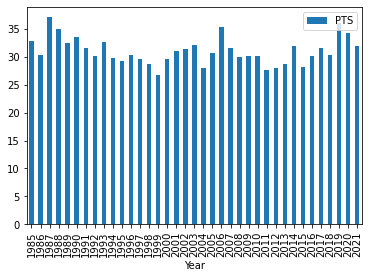

In [54]:
high_scores.plot.bar('Year','PTS')

Check correlation

In [55]:
stats.corr()['Share']

Age        0.018347
G          0.090419
GS         0.170719
MP         0.167443
FG         0.278770
FGA        0.252519
FG%        0.068611
3P         0.091031
3PA        0.091503
3P%        0.032538
2P         0.276027
2PA        0.252141
2P%        0.065814
eFG%       0.062521
FT         0.322276
FTA        0.322864
FT%        0.045243
ORB        0.108412
DRB        0.214973
TRB        0.189391
AST        0.207893
STL        0.186735
BLK        0.149246
TOV        0.236371
PF         0.072755
PTS        0.292657
Year      -0.012783
Pts Won    0.989503
Pts Max    0.517704
Share      1.000000
W          0.125582
L         -0.124060
W/L%       0.128641
GB        -0.103798
PS/G       0.046484
PA/G      -0.035297
SRS        0.123982
Name: Share, dtype: float64

<AxesSubplot:>

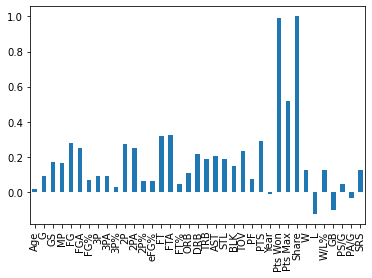

In [56]:
stats.corr()['Share'].plot.bar()

In [57]:
pd.isnull(stats).sum()

Player       0
Pos          0
Age          0
Tm           0
G            0
GS           0
MP           0
FG           0
FGA          0
FG%          0
3P           0
3PA          0
3P%          0
2P           0
2PA          0
2P%          0
eFG%         0
FT           0
FTA          0
FT%          0
ORB          0
DRB          0
TRB          0
AST          0
STL          0
BLK          0
TOV          0
PF           0
PTS          0
Year         0
Pts Won      0
Pts Max      0
Share        0
Team         0
W          366
L          366
W/L%       366
GB         366
PS/G       366
PA/G       366
SRS        366
dtype: int64

In [58]:
stats

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,Pts Max,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,A.C. Green,PF,22,LAL,82,1,18.8,2.5,4.7,0.539,...,0.0,0.0,Los Angeles Lakers,62.0,20.0,0.756,0.0,117.3,109.5,6.84
1,A.C. Green,PF,23,LAL,79,72,28.4,4.0,7.4,0.538,...,0.0,0.0,Los Angeles Lakers,65.0,17.0,0.793,0.0,117.8,108.5,8.32
2,A.C. Green,PF,24,LAL,82,64,32.1,3.9,7.8,0.503,...,0.0,0.0,Los Angeles Lakers,62.0,20.0,0.756,0.0,112.8,107.0,4.81
3,A.C. Green,PF,25,LAL,82,82,30.6,4.9,9.2,0.529,...,0.0,0.0,Los Angeles Lakers,57.0,25.0,0.695,0.0,114.7,107.5,6.38
4,A.C. Green,PF,26,LAL,82,82,33.0,4.7,9.8,0.478,...,0.0,0.0,Los Angeles Lakers,63.0,19.0,0.768,0.0,110.7,103.9,6.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16115,Željko Rebrača,C,29,DET,74,4,15.9,2.6,5.1,0.505,...,0.0,0.0,Detroit Pistons,50.0,32.0,0.610,0.0,94.3,92.2,1.69
16116,Željko Rebrača,C,30,DET,30,12,16.3,2.7,4.8,0.552,...,0.0,0.0,Detroit Pistons,50.0,32.0,0.610,0.0,91.4,87.7,2.97
16117,Željko Rebrača,C,31,ATL,24,2,11.4,1.4,3.2,0.442,...,0.0,0.0,Atlanta Hawks,28.0,54.0,0.341,33.0,92.8,97.5,-5.00
16118,Željko Rebrača,C,32,LAC,58,2,16.0,2.3,4.0,0.568,...,0.0,0.0,Los Angeles Clippers,37.0,45.0,0.451,25.0,95.7,96.5,-0.47
